# **multinomial random tree classifier for the whole model**

In [58]:
import pandas as pd 
import numpy as np 
import random
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
from sklearn import datasets

#following a multinomial clasification tutorial 
#https://www.codementor.io/@agarrahul01/multiclass-classification-using-random-forest-on-scikit-learn-library-hkk4lwawu
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import re
# from sklearn.externals import joblib

In [95]:
model_name = "model7"
tmp_file_path = "../../../"
model_desc = "_allTissueSpecTracks_bloodEquiv_noMethyl"
onlyMuts=True
standardizeMethod = "together"
tissue="global"
noTissueSpecPreds = False
error_log = model_desc+", standardize method = "+standardizeMethod+ ", only muts:  "+str(onlyMuts)+"\n"

In [96]:
if standardizeMethod == "together": 
    all_data = pd.read_csv("{p}data/global/dataframes/{m}/global_all_data_readyForPrediction{d}.csv".format(p=tmp_file_path,m=model_name,d=model_desc))
elif standardizeMethod == "seperate":
    #load df 
    blood_df = pd.read_csv("{p}data/blood/dataframes/{m}/blood_forLiver_all_data_readyForPrediction.csv".format(p=tmp_file_path,m=model_name))
    germline_df = pd.read_csv("{p}data/germline/dataframes/{m}/germline_forLiver_all_data_readyForPrediction.csv".format(p=tmp_file_path,m=model_name))
    skin_df = pd.read_csv("{p}data/skin/dataframes/{m}/skin_forLiver_all_data_readyForPrediction.csv".format(p=tmp_file_path,m=model_name))
    liver_df = pd.read_csv("{p}data/liver/dataframes/{m}/liver_all_data_readyForPrediction.csv".format(p=tmp_file_path,m=model_name))
    #sample larger models down to blood nrow 
    germline_df =germline_df.sample(n=blood_df.shape[0])
    liver_df =liver_df.sample(n=blood_df.shape[0])
    skin_df =skin_df.sample(n=blood_df.shape[0])
    #create a column to disinguish which tissue is which before merging 
    blood_df["tissue"]="blood"
    germline_df["tissue"]="germline"
    liver_df["tissue"]="liver"
    skin_df["tissue"]="skin"
    #merging the tissue data 
    all_data = pd.concat([blood_df,germline_df])
    all_data = pd.concat([all_data, liver_df])
    all_data = pd.concat([all_data,skin_df])
    #stadardizing the binary columns! (they were individually  standardized but we dont want that)
    #ok which columns are binary and need ot be edited? 
    binary_cols = []
    for feature in all_data.columns:
        if re.findall(r"(hromosome)|(riplet)|(nnotation)|(pGisland)|(methyl)",feature): 
            binary_cols.append(feature)
    #convertisng the contunuous (previously standardized) values back to binary 
    #(here, -1 and 1) where -1 = "not" and 1 = "yes"
    for feature in all_data.columns: 
        if feature in binary_cols: 
            all_data[[feature]] = all_data[[feature]]/abs(all_data[[feature]])
    #double checking the conversion worked 
    for feature in binary_cols: 
        col_index = all_data.columns.get_loc(feature)
        col_values = all_data.iloc[:,col_index].values
        assert set(list(col_values)) == {-1,1} #maes sure all the binary cols have either -1 or 1 as values 


In [97]:
all_data.columns

Index(['Unnamed: 0', 'Chromosomechr10', 'Chromosomechr11', 'Chromosomechr12',
       'Chromosomechr13', 'Chromosomechr14', 'Chromosomechr15',
       'Chromosomechr16', 'Chromosomechr17', 'Chromosomechr18',
       ...
       'DNAse_germline.0', 'DNAse_germline.100', 'DNAse_germline.10000',
       'Transcription_germline.0', 'Transcription_germline.100',
       'Transcription_germline.10000', 'GC_content.100', 'GC_content.10000',
       'mutation_status', 'tissue'],
      dtype='object', length=144)

In [98]:
if noTissueSpecPreds: 
    all_data = all_data.filter(regex="(Chrom|trip|recom|Repeats|annot|dist_rep|CpG|GC_content|mutation|tissue|Unnam)")#https://stackoverflow.com/questions/30808430/how-to-select-columns-from-dataframe-by-regex
    model_desc = model_desc+"_noTissueSpecPreds"
    

In [99]:
#remove annoying column 
all_data= all_data.drop(columns=['Unnamed: 0'])

if onlyMuts==True:
    all_data = all_data[all_data.mutation_status==1]
    all_data = all_data.drop(columns=["mutation_status"])
    model_desc=model_desc+"_onlyMuts"
else: model_desc=model_desc+"_mutsAndNon"
    

In [100]:
# code previously from when i was sleting for previous all_data = all_data[(all_data.tissue == "skin")|(all_data.tissue == "germline")]

In [101]:
#need to convert the dependant class into number representation
factor = pd.factorize(all_data['tissue'])
all_data.tissue = factor[0]
definitions = factor[1]

In [102]:
#seperating the predictors from response
ncol = (all_data.shape[1])
X = all_data.iloc[:,0:ncol-1].values
y = all_data.iloc[:,ncol-1].values

In [103]:
model_desc

'_allTissueSpecTracks_bloodEquiv_noMethyl_onlyMuts'

In [104]:

#getting the testing and training data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [105]:

#scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#the actual model 
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)
#analysing accuracy: tyhe confusion matrix
y_pred = classifier.predict(X_test)
reversefactor = dict(zip(range(4),definitions))#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual Tissue'], colnames=['Predicted Tissue'])
confusion_matrix.to_csv("{f}data/{t}/dataframes/{m}/multinomModelConfusionMatrix{d}.csv".format(f=tmp_file_path,t=tissue,m=model_name,d=model_desc))

In [106]:
confusion_matrix

Predicted Tissue,blood,germline,liver,skin
Actual Tissue,,,,
blood,656,404,350,292
germline,542,515,351,227
liver,561,466,378,287
skin,497,339,319,555


In [93]:
confusion_matrix

Predicted Tissue,blood,germline,liver,skin
Actual Tissue,,,,
blood,1085,38,29,65
germline,8,1483,25,9
liver,28,65,1566,28
skin,66,20,52,1437


In [47]:
confusion_matrix

Predicted Tissue,blood,germline,liver,skin
Actual Tissue,,,,
blood,656,404,350,292
germline,542,515,351,227
liver,561,466,378,287
skin,497,339,319,555


In [107]:
def get_sensitivity(df,tissue):
    """input a df, get out the sensitivity for the tissue of interest 
    note the row names have to be the actuall tissue and colnames = predicted tissue"""
    tissues = list(definitions) #the definitions already stores the tissues
    tissues.remove(tissue)
    P = sum(df.loc[[tissue]].values[0])
    TP = df.loc[[tissue]][[tissue]].values[0][0]
    return(TP/P)
def get_specificity(df,tissue):
    """input a df and a tissue, and you'll get the specificity: TN/N
    note the row names have to be the actuall tissue and colnames = predicted tissue"""
    tissues = list(definitions) #the definitions already stores the tissues
    tissues.remove(tissue)
    N=sum(df.loc[tissues].sum(axis=1))
    TN = sum(df.loc[tissues][tissues].sum(axis=1))
    return(TN/N)
for tissue in list(definitions):
    print(tissue," specificity", round(get_specificity(confusion_matrix,tissue),3))
    error_log += tissue+" specificity "+str(round(get_specificity(confusion_matrix,tissue),3))+"\n"
for tissue in list(definitions):
    print(tissue," sensitivity", round(get_sensitivity(confusion_matrix,tissue),3))
    error_log += tissue+" sensitivity "+ str(round(get_sensitivity(confusion_matrix,tissue),3))+"\n"

blood  specificity 0.682
germline  specificity 0.763
liver  specificity 0.798
skin  specificity 0.84
blood  sensitivity 0.385
germline  sensitivity 0.315
liver  sensitivity 0.223
skin  sensitivity 0.325


In [108]:
#extracting feature names and making them human easthetically pleasing for the plot 
features = all_data.columns
for i,feature in enumerate(features): 
    features[i]
feature_name_improve = {}
for feature in features: 
    feature_name_improve[feature] = feature
features=list(features)
for i,feature in enumerate(features): 
    feature = re.sub(r"(.100)$"," at 100bp",feature)
    feature=re.sub(r"(.10000)$"," at 10kbp",feature)
    feature =re.sub(r"dist_rep_org_all","Distance to any RO",feature)
    feature=re.sub(r"dist_rep_org_main","Distance to main ROs",feature)
    feature=re.sub(r"Annotation","Annotation: ",feature)
    feature=re.sub(r"Chromosome","Chromosome: ",feature)
    feature=re.sub(r"Triplet","Triplet: ",feature)
    feature=re.sub(r"GC_content","GC content",feature)
    
    feature=feature[0].upper()+feature[1:]#capitalize first letter
    features[i] = feature

In [109]:
import matplotlib.patches as mpatches

Site no match!!


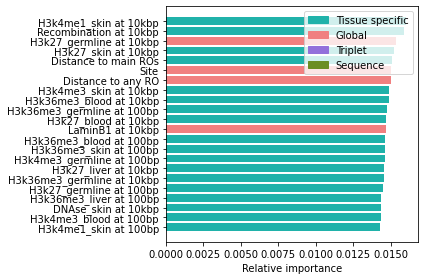

In [111]:
#plotting the importances 

importances= classifier.feature_importances_
indices = np.argsort(importances)[-22:]
types = []
for feature in [features[i] for i in indices]: 
    if re.search(r"percent",feature):types.append("sequence")
    elif re.search(r"Chromosome",feature):types.append("sequence")
    elif re.search(r"Repeats",feature):types.append("sequence")
    elif re.search(r"site",feature):types.append("sequence")
    elif re.search(r"annot",feature):types.append("sequence")
    elif re.search(r"content",feature):types.append("sequence")
    elif re.search(r"CpG",feature):types.append("sequence")

    elif re.search(r"riplet",feature):types.append("triplet")

    elif re.search(r"DNAse",feature):types.append("tissue_specific")
    elif re.search(r"Transcription",feature):types.append("tissue_specific")
    elif re.search(r"H3k",feature):types.append("tissue_specific")
    elif re.search(r"methyl",feature):types.append("tissue_specific")

    elif re.search(r"ecomb",feature):types.append("global")
    elif re.search(r"amin",feature):types.append("global")
    elif re.search(r"eplication",feature):types.append("global")
    elif re.search(r"istance",feature):types.append("global")

    elif re.search(r"ntercept",feature):types.append("intercept")
    else: print(feature,"no match!!")
type_color_translate_dict = {"triplet":"mediumpurple","sequence":'olivedrab',"tissue_specific":'lightseagreen',"global":'lightcoral'}
colors = [type_color_translate_dict[type] for type in types]
# plt.title("fueature importnace: {t}".format(t=tissue))
plt.barh(range(len(indices)),importances[indices],color=colors,align="center")
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel("Relative importance")
plt.tight_layout()
TS_patch = mpatches.Patch(color='lightseagreen', label='Tissue specific')#https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend
G_patch = mpatches.Patch(color='lightcoral', label='Global')
T_patch = mpatches.Patch(color='mediumpurple', label='Triplet')
S_patch = mpatches.Patch(color='olivedrab', label='Sequence')
plt.legend(handles=[TS_patch,G_patch,T_patch,S_patch])
# plt.show()
plt.savefig("{t}/analysis/global/plots/{m}/regtreeImportances{d}.pdf".format(t=tmp_file_path,m=model_name,d=model_desc))  

# scratch 

TypeError: can only concatenate str (not "numpy.int64") to str

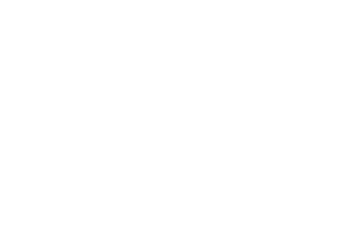

In [166]:
# https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7
from sklearn.tree import plot_tree
# Extract single tree
estimator = classifier.estimators_[5]

# Export as dot file
plot_tree(classifier.estimators_[5], 
        feature_names = list(all_data.iloc[:,0:ncol-1].columns),
        class_names = y,
        filled=True, impurity=True, 
        rounded=True)



In [159]:
list(all_data.iloc[:,0:ncol-1].columns)

['Chromosomechr10',
 'Chromosomechr11',
 'Chromosomechr12',
 'Chromosomechr13',
 'Chromosomechr14',
 'Chromosomechr15',
 'Chromosomechr16',
 'Chromosomechr17',
 'Chromosomechr18',
 'Chromosomechr19',
 'Chromosomechr2',
 'Chromosomechr20',
 'Chromosomechr21',
 'Chromosomechr22',
 'Chromosomechr3',
 'Chromosomechr4',
 'Chromosomechr5',
 'Chromosomechr6',
 'Chromosomechr7',
 'Chromosomechr8',
 'Chromosomechr9',
 'tripletACC',
 'tripletACG',
 'tripletACT',
 'tripletATA',
 'tripletATC',
 'tripletATG',
 'tripletATT',
 'tripletCCA',
 'tripletCCC',
 'tripletCCG',
 'tripletCCT',
 'tripletCTA',
 'tripletCTC',
 'tripletCTG',
 'tripletCTT',
 'tripletGCA',
 'tripletGCC',
 'tripletGCG',
 'tripletGCT',
 'tripletGTA',
 'tripletGTC',
 'tripletGTG',
 'tripletGTT',
 'tripletTCA',
 'tripletTCC',
 'tripletTCG',
 'tripletTCT',
 'tripletTTA',
 'tripletTTC',
 'tripletTTG',
 'tripletTTT',
 'H3k27.10000',
 'H3k4me1.10000',
 'H3k4me3.10000',
 'DNAse.100',
 'Transcription.10000',
 'H3k36me3.10000',
 'laminB1.0',


In [155]:
from sklearn.datasets import load_wine

In [157]:
wine = load_wine()

In [161]:
y

array([0, 0, 0, ..., 3, 3, 3])

In [160]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [2]:
# iris = datasets.load_iris()
# X = iris.data[:, 2:]
# y = iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# forest = RandomForestClassifier(criterion='gini',n_estimators=5,random_state=1,n_jobs=2)
# # Fit the model
# #
# forest.fit(X_train, y_train)
# # Measure model performance
# #
# y_pred = forest.predict(X_test)
# print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))